# Исследование датасета BCI Competition III Dataset II и формирование выборок для дипломной работы

Какие выборки нужно сформировать?
- Обучающая выборка: Dataset II-A
    - Subject_A_Train.mat : 15 300 trials = 85 chars × 15 reps × 12 stimuli


- Бенчмарк: Dataset II-B
    - - Subject_B_Train.mat : 15 300 trials = 85 chars × 15 reps × 12 stimuli


### Препроцессинг
Каналы: ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'C3', 'C4', 'CP3', 'CP4']

Фильтрация band-pass 0.1–20 Гц

Ресемплинг к 256 Гц

Эпохи 0–800 мс post-stimulus

Паддинг до 208 отсчётов

Z-score по train (Subject A)


## Загрузка

In [4]:
from pathlib import Path
import scipy.io as sio
import numpy as np

# --- CONFIG ---
FS_RAW = 240  # по документации
DATA_DIR = Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Датасеты\BCI Competition III The dataset II\BCI_Comp_III_Wads_2004")

FILE_A = DATA_DIR / "Subject_A_Train.mat"
FILE_B = DATA_DIR / "Subject_B_Train.mat"

# --- LOADER ---
def load_bci_comp3_ds2_mat(mat_path: Path) -> dict:
    """
    Загружает .mat BCI Competition III Dataset II (Wadsworth 2004).
    Возвращает словарь с массивами:
      Signal: (n_blocks, n_samples, 64) float32
      Flashing: (n_blocks, n_samples) float
      StimulusCode: (n_blocks, n_samples) float/int
      StimulusType: (n_blocks, n_samples) float
      TargetChar: (n_blocks,) unicode (если есть)
    """
    mat = sio.loadmat(str(mat_path))
    required = ["Signal", "Flashing", "StimulusCode", "StimulusType"]
    missing = [k for k in required if k not in mat]
    if missing:
        raise KeyError(f"Missing keys in {mat_path.name}: {missing}")

    out = {
        "path": str(mat_path),
        "Signal": mat["Signal"],
        "Flashing": mat["Flashing"],
        "StimulusCode": mat["StimulusCode"],
        "StimulusType": mat["StimulusType"],
    }

    # TargetChar есть в Train, но на всякий случай делаем мягко
    if "TargetChar" in mat:
        tc = mat["TargetChar"]
        # часто это shape (1, n_blocks) с dtype '<U1' или object
        out["TargetChar"] = tc.ravel()
    else:
        out["TargetChar"] = None

    return out

def inspect_loaded(ds: dict, name: str) -> None:
    Signal = ds["Signal"]
    Flashing = ds["Flashing"]
    StimulusCode = ds["StimulusCode"]
    StimulusType = ds["StimulusType"]

    print(f"\n=== {name} ===")
    print("file:", ds["path"])
    print("Signal:", Signal.shape, Signal.dtype)
    print("Flashing:", Flashing.shape, "unique:", np.unique(Flashing)[:5])
    print("StimulusCode:", StimulusCode.shape, "unique sample:", np.unique(StimulusCode)[:10])
    print("StimulusType:", StimulusType.shape, "unique:", np.unique(StimulusType)[:5])

    # базовые проверки
    assert Signal.ndim == 3 and Signal.shape[2] == 64, "Signal must be (blocks, samples, 64)"
    assert Flashing.shape == Signal.shape[:2], "Flashing shape must match (blocks, samples)"
    assert StimulusCode.shape == Signal.shape[:2], "StimulusCode shape must match (blocks, samples)"
    assert StimulusType.shape == Signal.shape[:2], "StimulusType shape must match (blocks, samples)"

    # проверка бинарности (мягкая)
    f_vals = set(np.unique(Flashing).tolist())
    t_vals = set(np.unique(StimulusType).tolist())
    if not f_vals.issubset({0.0, 1.0}):
        print("WARN: Flashing not strictly binary:", sorted(list(f_vals))[:10])
    if not t_vals.issubset({0.0, 1.0}):
        print("WARN: StimulusType not strictly binary:", sorted(list(t_vals))[:10])

    tc = ds.get("TargetChar", None)
    if tc is not None:
        print("TargetChar len:", len(tc))

# --- LOAD A & B ---
dsA = load_bci_comp3_ds2_mat(FILE_A)
inspect_loaded(dsA, "Subject A (Train)")

dsB = load_bci_comp3_ds2_mat(FILE_B)
inspect_loaded(dsB, "Subject B (Train / Benchmark)")



=== Subject A (Train) ===
file: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Датасеты\BCI Competition III The dataset II\BCI_Comp_III_Wads_2004\Subject_A_Train.mat
Signal: (85, 7794, 64) float32
Flashing: (85, 7794) unique: [0. 1.]
StimulusCode: (85, 7794) unique sample: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
StimulusType: (85, 7794) unique: [0. 1.]
TargetChar len: 1

=== Subject B (Train / Benchmark) ===
file: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Датасеты\BCI Competition III The dataset II\BCI_Comp_III_Wads_2004\Subject_B_Train.mat
Signal: (85, 7794, 64) float32
Flashing: (85, 7794) unique: [0. 1.]
StimulusCode: (85, 7794) unique sample: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
StimulusType: (85, 7794) unique: [0. 1.]
TargetChar len: 1


## Выбор 14 каналов

In [5]:
import numpy as np

CHANNELS_14 = ['Fz','Cz','Pz','Oz','P3','P4','PO7','PO8','F3','F4','C3','C4','CP3','CP4']

# маппинг из Figure 2 (1-based -> переведено в 0-based)
CH_TO_IDX0 = {
    'Fz': 33, 'Cz': 10, 'Pz': 50, 'Oz': 61,
    'P3': 48, 'P4': 52, 'PO7': 55, 'PO8': 59,
    'F3': 31, 'F4': 35, 'C3': 8,  'C4': 12,
    'CP3': 15,'CP4': 19,
}

IDX0_14 = [CH_TO_IDX0[ch] for ch in CHANNELS_14]

def select_channels_14(ds: dict) -> dict:
    """
    Добавляет в ds поле Signal14: (n_blocks, n_samples, 14) float32
    Каналы в порядке CHANNELS_14.
    """
    sig = ds["Signal"]
    sig14 = sig[:, :, IDX0_14].astype(np.float32, copy=False)
    out = dict(ds)  # shallow copy
    out["Signal14"] = sig14
    out["channels_14"] = CHANNELS_14
    return out

def inspect_signal14(ds: dict, name: str) -> None:
    sig14 = ds["Signal14"]
    print(f"\n=== {name}: Signal14 ===")
    print("Signal14:", sig14.shape, sig14.dtype)
    # sanity: нет ли NaN/inf
    print("finite:", np.isfinite(sig14).all(), "| min:", float(sig14.min()), "max:", float(sig14.max()))

# применяем
dsA = select_channels_14(dsA)
inspect_signal14(dsA, "Subject A")

dsB = select_channels_14(dsB)
inspect_signal14(dsB, "Subject B")



=== Subject A: Signal14 ===
Signal14: (85, 7794, 14) float32
finite: True | min: -148.82945251464844 max: 194.5260009765625

=== Subject B: Signal14 ===
Signal14: (85, 7794, 14) float32
finite: True | min: -117.95024871826172 max: 135.1838836669922


## Фильтрация 0.1–20 Гц (FIR, zero-phase)

In [8]:
import numpy as np
from scipy.signal import firwin, filtfilt

# --- FILTER CONFIG ---
FS_RAW = 240
F_LO, F_HI = 0.1, 20.0

def design_fir_bandpass(fs: float, f_lo: float, f_hi: float, numtaps: int = 801):
    """
    FIR band-pass через firwin.
    numtaps должен быть нечётным.
    """
    if numtaps % 2 == 0:
        raise ValueError("numtaps must be odd for linear-phase FIR.")
    taps = firwin(
        numtaps=numtaps,
        cutoff=[f_lo, f_hi],
        pass_zero=False,
        fs=fs
    )
    return taps

TAPS = design_fir_bandpass(FS_RAW, F_LO, F_HI, numtaps=801)

def bandpass_filtfilt_blocks(signal14: np.ndarray, taps: np.ndarray) -> np.ndarray:
    """
    signal14: (n_blocks, n_samples, n_ch)
    Возвращает отфильтрованный сигнал той же формы.
    Фильтруем по оси времени (axis=1) отдельно для каждого блока и канала.
    """
    x = signal14.astype(np.float64, copy=False)  # filtfilt любит float64 для стабильности
    y = np.empty_like(x)

    for bi in range(x.shape[0]):
        # filtfilt применяем сразу ко всем каналам блока: (n_samples, n_ch) по axis=0
        # Поэтому транспонируем: (n_samples, n_ch) и фильтруем вдоль sample-оси (axis=0)
        block = x[bi]  # (n_samples, n_ch)
        y[bi] = filtfilt(taps, [1.0], block, axis=0, padtype="odd")
    return y.astype(np.float32)

# --- APPLY ---
dsA["Signal14_filt"] = bandpass_filtfilt_blocks(dsA["Signal14"], TAPS)
dsB["Signal14_filt"] = bandpass_filtfilt_blocks(dsB["Signal14"], TAPS)

print("A filtered:", dsA["Signal14_filt"].shape, dsA["Signal14_filt"].dtype)
print("B filtered:", dsB["Signal14_filt"].shape, dsB["Signal14_filt"].dtype)

# sanity: конечные значения
print("A finite:", np.isfinite(dsA["Signal14_filt"]).all())
print("B finite:", np.isfinite(dsB["Signal14_filt"]).all())


A filtered: (85, 7794, 14) float32
B filtered: (85, 7794, 14) float32
A finite: True
B finite: True


In [9]:
# Быстрая проверка
def quick_stats(x, name):
    print(name, "mean:", float(x.mean()), "std:", float(x.std()),
          "min:", float(x.min()), "max:", float(x.max()))

quick_stats(dsA["Signal14"], "A raw")
quick_stats(dsA["Signal14_filt"], "A filt")
quick_stats(dsB["Signal14"], "B raw")
quick_stats(dsB["Signal14_filt"], "B filt")


A raw mean: -0.4019910395145416 std: 18.56355094909668 min: -148.82945251464844 max: 194.5260009765625
A filt mean: -0.027447624132037163 std: 14.63817310333252 min: -184.86097717285156 max: 222.73619079589844
B raw mean: -0.8717173933982849 std: 14.435439109802246 min: -117.95024871826172 max: 135.1838836669922
B filt mean: -0.3510347008705139 std: 11.124582290649414 min: -112.42784118652344 max: 131.36703491210938


## Ресемплинг (240 -> 256 Гц)

In [ ]:
# Ресемплинг сигнала

import numpy as np
from scipy.signal import resample_poly
from math import gcd

FS_RAW = 240
FS_TARGET = 256

def resample_blocks_poly(x_blocks: np.ndarray, fs_in: int, fs_out: int) -> np.ndarray:
    """
    x_blocks: (n_blocks, n_samples, n_ch)
    Возвращает (n_blocks, n_samples_new, n_ch) после resample_poly.
    """
    g = gcd(fs_in, fs_out)
    up = fs_out // g
    down = fs_in // g

    y_list = []
    for bi in range(x_blocks.shape[0]):
        block = x_blocks[bi]  # (n_samples, n_ch)
        # ресемплим по оси времени (axis=0), одновременно все каналы
        yb = resample_poly(block, up=up, down=down, axis=0)
        y_list.append(yb.astype(np.float32, copy=False))

    # длина у всех блоков будет одинаковая, можно stack
    y = np.stack(y_list, axis=0)
    return y

# применяем к отфильтрованному сигналу
dsA["Signal14_rs"] = resample_blocks_poly(dsA["Signal14_filt"], FS_RAW, FS_TARGET)
dsB["Signal14_rs"] = resample_blocks_poly(dsB["Signal14_filt"], FS_RAW, FS_TARGET)

print("A resampled:", dsA["Signal14_rs"].shape, dsA["Signal14_rs"].dtype)
print("B resampled:", dsB["Signal14_rs"].shape, dsB["Signal14_rs"].dtype)

# sanity
print("A finite:", np.isfinite(dsA["Signal14_rs"]).all())
print("B finite:", np.isfinite(dsB["Signal14_rs"]).all())

# ожидаемая новая длина блока
n_in = dsA["Signal14_filt"].shape[1]
n_expected = int(round(n_in * FS_TARGET / FS_RAW))
print("n_in:", n_in, "n_expected ~", n_expected, "| n_out:", dsA["Signal14_rs"].shape[1])


A resampled: (85, 8314, 14) float32
B resampled: (85, 8314, 14) float32
A finite: True
B finite: True
n_in: 7794 n_expected ~ 8314 | n_out: 8314


Как сделать ресемплинг "собыьтийных" массивов (flashing, stim_code, stim_type):
- находим onset’ы на сырой сетке 240 Гц по Flashing (0→1)
- переводим в секунды t = onset / 240
- переводим в индексы на 256 Гц: onset_256 = round(t * 256)
- сразу собираем “таблицу событий” с метками y (из StimulusType)

In [11]:
import numpy as np

FS_RAW = 240
FS_TARGET = 256

def extract_onsets_01(flashing_1d: np.ndarray) -> np.ndarray:
    """Индексы onset'ов: позиции, где flashing 0->1."""
    f = flashing_1d.astype(np.int8)
    return np.where((f[1:] == 1) & (f[:-1] == 0))[0] + 1

def map_onsets_to_new_fs(onsets_raw: np.ndarray, fs_in: int, fs_out: int) -> np.ndarray:
    """
    Перевод индексов onset с fs_in в fs_out через время.
    Используем round для стабильности.
    """
    t_sec = onsets_raw / float(fs_in)
    onsets_new = np.round(t_sec * fs_out).astype(np.int32)
    return onsets_new

def build_events_table(ds: dict, fs_in: int, fs_out: int) -> dict:
    """
    Строит события для всего датасета (всех блоков).
    Добавляет:
      events: np.ndarray shape (N_events, 6)
        cols = [block_id, onset_raw, onset_rs, y, stim_code, event_order]
      fs_in, fs_out
    """
    Flashing = ds["Flashing"]
    StimulusType = ds["StimulusType"]
    StimulusCode = ds["StimulusCode"]

    rows = []
    event_order = 0

    n_blocks = Flashing.shape[0]
    for bi in range(n_blocks):
        on_raw = extract_onsets_01(Flashing[bi])
        on_rs = map_onsets_to_new_fs(on_raw, fs_in, fs_out)

        # метки и код берём в момент onset на исходной сетке
        y = (StimulusType[bi, on_raw] > 0.5).astype(np.int8)
        code = StimulusCode[bi, on_raw].astype(np.int16)

        for j in range(len(on_raw)):
            rows.append([bi, int(on_raw[j]), int(on_rs[j]), int(y[j]), int(code[j]), event_order])
            event_order += 1

    events = np.array(rows, dtype=np.int32)

    out = dict(ds)
    out["events"] = events
    out["fs_in"] = fs_in
    out["fs_out"] = fs_out
    return out

def inspect_events(ds: dict, name: str) -> None:
    ev = ds["events"]
    print(f"\n=== {name}: events ===")
    print("events shape:", ev.shape, "(cols: block, onset_raw, onset_rs, y, code, order)")
    print("y counts:", np.bincount(ev[:,3].astype(np.int64)))
    print("unique codes (sample):", np.unique(ev[:,4])[:12])
    print("first 5 rows:\n", ev[:5])

# применяем к A и B
dsA = build_events_table(dsA, FS_RAW, FS_TARGET)
inspect_events(dsA, "Subject A")

dsB = build_events_table(dsB, FS_RAW, FS_TARGET)
inspect_events(dsB, "Subject B")



=== Subject A: events ===
events shape: (15215, 6) (cols: block, onset_raw, onset_rs, y, code, order)
y counts: [12678  2537]
unique codes (sample): [ 1  2  3  4  5  6  7  8  9 10 11 12]
first 5 rows:
 [[  0  42  45   0  11   0]
 [  0  84  90   0   3   1]
 [  0 126 134   0  10   2]
 [  0 168 179   0   9   3]
 [  0 210 224   1   7   4]]

=== Subject B: events ===
events shape: (15215, 6) (cols: block, onset_raw, onset_rs, y, code, order)
y counts: [12679  2536]
unique codes (sample): [ 1  2  3  4  5  6  7  8  9 10 11 12]
first 5 rows:
 [[  0  42  45   0   3   0]
 [  0  84  90   0   8   1]
 [  0 126 134   0   9   2]
 [  0 168 179   1   4   3]
 [  0 210 224   0   5   4]]


#### Проверки

In [12]:
# Проверяем, что Onset’ы не выходят за длину ресемпленного блока
def check_onsets_within_bounds(ds: dict, name: str):
    ev = ds["events"]
    sig_rs = ds["Signal14_rs"]
    n_samples_rs = sig_rs.shape[1]
    # onset_rs должен быть < n_samples_rs
    bad = np.where(ev[:,2] < 0)[0]
    bad2 = np.where(ev[:,2] >= n_samples_rs)[0]
    print(f"{name}: onset_rs min={ev[:,2].min()} max={ev[:,2].max()} | n_samples_rs={n_samples_rs}")
    assert len(bad) == 0, "Negative onset_rs found"
    assert len(bad2) == 0, f"onset_rs beyond block length: {len(bad2)}"

check_onsets_within_bounds(dsA, "A")
check_onsets_within_bounds(dsB, "B")


A: onset_rs min=45 max=8019 | n_samples_rs=8314
B: onset_rs min=45 max=8019 | n_samples_rs=8314


In [13]:
# Проверяем, что хватает места для окна 0–800 мс
EPOCH_SEC = 0.8
L_RAW = int(round(EPOCH_SEC * FS_TARGET))  # ~205

def check_epoch_fits(ds: dict, name: str, L_raw: int):
    ev = ds["events"]
    n_samples_rs = ds["Signal14_rs"].shape[1]
    # onset_rs + L_raw <= n_samples_rs
    end = ev[:,2] + L_raw
    bad = np.where(end > n_samples_rs)[0]
    print(f"{name}: L_raw={L_raw} | bad epochs={len(bad)}")
    # если bad > 0, можно либо отбрасывать эти события, либо укорачивать окно (мы лучше отбросим)
    return bad

badA = check_epoch_fits(dsA, "A", L_RAW)
badB = check_epoch_fits(dsB, "B", L_RAW)


A: L_raw=205 | bad epochs=0
B: L_raw=205 | bad epochs=0


## Нарезка  эпох (0-800 мс)

In [14]:
import numpy as np

FS_TARGET = 256
EPOCH_SEC = 0.8
L_RAW = int(round(EPOCH_SEC * FS_TARGET))  # 205

def epoch_from_events(ds: dict, L_raw: int) -> dict:
    """
    Нарезает эпохи из ds["Signal14_rs"] по ds["events"].
    Возвращает новый dict с:
      X_raw: (N_trials, C, L_raw) float32
      y: (N_trials,) int8
      event_order: (N_trials,) int32
      block_id: (N_trials,) int16
      onset_rs: (N_trials,) int32
      stim_code: (N_trials,) int16
    """
    sig_rs = ds["Signal14_rs"]  # (n_blocks, n_samples_rs, n_ch)
    ev = ds["events"]           # cols: block, onset_raw, onset_rs, y, code, order

    n_trials = ev.shape[0]
    n_ch = sig_rs.shape[2]

    X = np.empty((n_trials, n_ch, L_raw), dtype=np.float32)
    y = ev[:, 3].astype(np.int8)
    event_order = ev[:, 5].astype(np.int32)
    block_id = ev[:, 0].astype(np.int16)
    onset_rs = ev[:, 2].astype(np.int32)
    stim_code = ev[:, 4].astype(np.int16)

    for i in range(n_trials):
        bi = block_id[i]
        s = onset_rs[i]
        seg = sig_rs[bi, s:s+L_raw, :]          # (L_raw, n_ch)
        X[i] = seg.T                             # -> (n_ch, L_raw)

    out = dict(ds)
    out["X_raw"] = X
    out["y"] = y
    out["event_order"] = event_order
    out["block_id"] = block_id
    out["onset_rs"] = onset_rs
    out["stim_code"] = stim_code
    out["L_raw"] = L_raw
    out["fs"] = FS_TARGET
    return out

def inspect_epochs(ds: dict, name: str):
    X = ds["X_raw"]
    y = ds["y"]
    print(f"\n=== {name}: epochs ===")
    print("X_raw:", X.shape, X.dtype)  # (N, C, L_raw)
    print("y counts:", np.bincount(y.astype(np.int64)))
    print("finite:", np.isfinite(X).all(), "| mean:", float(X.mean()), "std:", float(X.std()))

# применяем
dsA = epoch_from_events(dsA, L_RAW)
inspect_epochs(dsA, "Subject A")

dsB = epoch_from_events(dsB, L_RAW)
inspect_epochs(dsB, "Subject B")



=== Subject A: epochs ===
X_raw: (15215, 14, 205) float32
y counts: [12678  2537]
finite: True | mean: -0.2499135434627533 std: 14.028815269470215

=== Subject B: epochs ===
X_raw: (15215, 14, 205) float32
y counts: [12679  2536]
finite: True | mean: -0.44980886578559875 std: 10.946258544921875


#### Проверка: строим ПСС target vs non-target

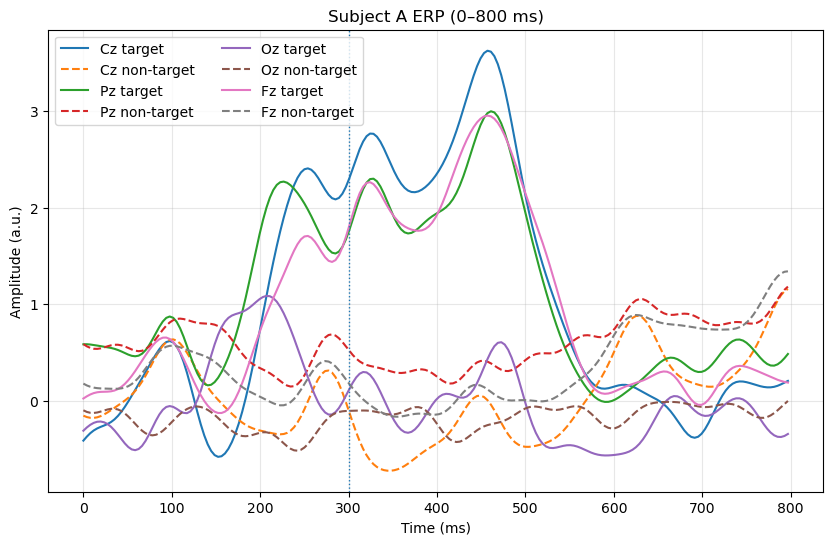

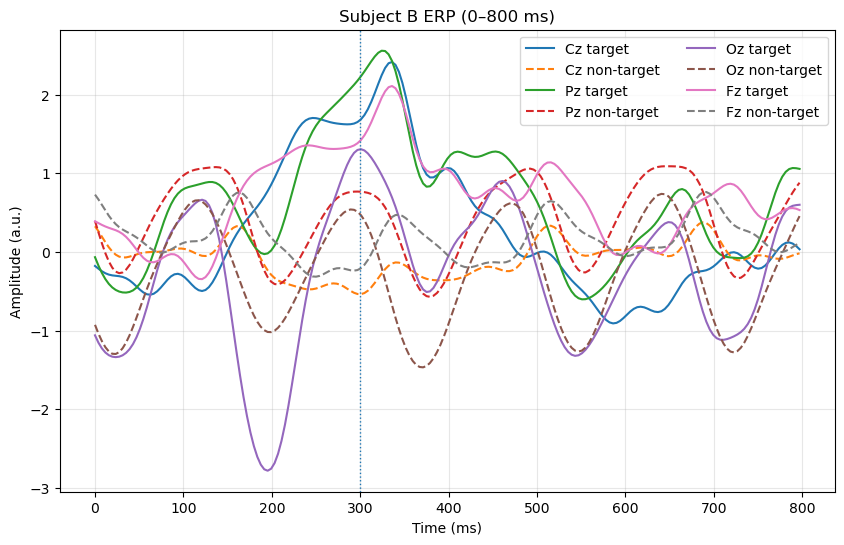

In [15]:
import numpy as np
import matplotlib.pyplot as plt

FS = dsA["fs"]          # 256
L = dsA["L_raw"]        # 205
t_ms = np.arange(L) / FS * 1000

# какие каналы рисуем
channels = dsA["channels_14"]
ch_idx = {ch:i for i,ch in enumerate(channels)}
plot_ch = ["Cz", "Pz", "Oz", "Fz"]  
plot_idx = [ch_idx[ch] for ch in plot_ch]

def erp_by_class(ds, baseline_ms=None):
    """
    baseline_ms: None или (t0, t1) в мс внутри окна, например (0, 50)
    """
    X = ds["X_raw"].copy()  # (N,C,L)
    y = ds["y"]

    if baseline_ms is not None:
        t0, t1 = baseline_ms
        i0 = int(round(t0/1000 * FS))
        i1 = int(round(t1/1000 * FS))
        base = X[:, :, i0:i1].mean(axis=2, keepdims=True)
        X = X - base

    X_t = X[y == 1]  # target
    X_n = X[y == 0]  # non-target
    erp_t = X_t.mean(axis=0)  # (C,L)
    erp_n = X_n.mean(axis=0)
    return erp_t, erp_n

def plot_erp(ds, title, baseline_ms=None):
    erp_t, erp_n = erp_by_class(ds, baseline_ms=baseline_ms)

    plt.figure(figsize=(10, 6))
    for ch, i in zip(plot_ch, plot_idx):
        plt.plot(t_ms, erp_t[i], label=f"{ch} target")
        plt.plot(t_ms, erp_n[i], linestyle="--", label=f"{ch} non-target")
    plt.axvline(300, linestyle=":", linewidth=1)  # ориентир P300
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (a.u.)")
    plt.title(title + ("" if baseline_ms is None else f" | baseline {baseline_ms[0]}–{baseline_ms[1]} ms"))
    plt.legend(ncol=2)
    plt.grid(True, alpha=0.3)
    plt.show()

# 1) без baseline
plot_erp(dsA, "Subject A ERP (0–800 ms)", baseline_ms=None)
plot_erp(dsB, "Subject B ERP (0–800 ms)", baseline_ms=None)

# 2) (опционально) baseline по 0–50 мс
# plot_erp(dsA, "Subject A ERP (0–800 ms)", baseline_ms=(0, 50))
# plot_erp(dsB, "Subject B ERP (0–800 ms)", baseline_ms=(0, 50))


## Паддинг до 208 

Только справа и только нулями

In [16]:
import numpy as np

L_PAD = 208

def pad_epochs_right(X_raw: np.ndarray, L_pad: int, pad_value: float = 0.0) -> np.ndarray:
    """
    X_raw: (N, C, L_raw)
    Возвращает X_pad: (N, C, L_pad), паддинг справа.
    Если L_raw > L_pad — обрежет справа (но у нас сейчас 205 -> 208).
    """
    N, C, L_raw = X_raw.shape
    if L_raw == L_pad:
        return X_raw
    if L_raw > L_pad:
        return X_raw[:, :, :L_pad]

    X_pad = np.full((N, C, L_pad), pad_value, dtype=X_raw.dtype)
    X_pad[:, :, :L_raw] = X_raw
    return X_pad

def apply_padding(ds: dict, L_pad: int) -> dict:
    """
    Добавляет:
      X: (N, C, L_pad)
      L_pad
    """
    out = dict(ds)
    out["X"] = pad_epochs_right(ds["X_raw"], L_pad=L_pad, pad_value=0.0)
    out["L_pad"] = L_pad
    return out

def inspect_padding(ds: dict, name: str):
    X_raw = ds["X_raw"]
    X = ds["X"]
    print(f"\n=== {name}: padding ===")
    print("X_raw:", X_raw.shape, "-> X:", X.shape, "| dtype:", X.dtype)
    # проверим, что первые L_raw совпадают
    L_raw = ds["L_raw"]
    max_diff = np.max(np.abs(X[:, :, :L_raw] - X_raw))
    print("max_diff (first L_raw):", float(max_diff))
    # проверим, что паддинг нулевой
    pad_part = X[:, :, L_raw:]
    print("pad unique (sample):", np.unique(pad_part)[:5], "| pad_shape:", pad_part.shape)

# применяем
dsA = apply_padding(dsA, L_PAD)
inspect_padding(dsA, "Subject A")

dsB = apply_padding(dsB, L_PAD)
inspect_padding(dsB, "Subject B")



=== Subject A: padding ===
X_raw: (15215, 14, 205) -> X: (15215, 14, 208) | dtype: float32
max_diff (first L_raw): 0.0
pad unique (sample): [0.] | pad_shape: (15215, 14, 3)

=== Subject B: padding ===
X_raw: (15215, 14, 205) -> X: (15215, 14, 208) | dtype: float32
max_diff (first L_raw): 0.0
pad unique (sample): [0.] | pad_shape: (15215, 14, 3)


## Сохранение базовых эпох

In [ ]:
from pathlib import Path
import numpy as np
import json
from datetime import datetime

# --- PATHS ---
OUT_ROOT = Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки") / "BCICompIII_DS2"
EPOCHS_DIR = OUT_ROOT / "epochs"
# LOGS_DIR = OUT_ROOT / "logs"
EPOCHS_DIR.mkdir(parents=True, exist_ok=True)
# LOGS_DIR.mkdir(parents=True, exist_ok=True)

VERSION = "v1"
FS_TARGET = dsA["fs"]          # 256
CHANNELS_14 = dsA["channels_14"]
L_RAW = int(dsA["L_raw"])
L_PAD = int(dsA["L_pad"])

def save_epochs_npz(ds: dict, out_path: Path, dataset_name: str):
    """
    Сохраняет базовые (не нормализованные) эпохи:
      X: (N,C,L_pad) padded
      y, event_order, block_id, onset_rs, stim_code
    И метаданные в отдельный json.
    """
    X = ds["X"]                      # padded
    y = ds["y"]
    event_order = ds["event_order"]
    block_id = ds["block_id"]
    onset_rs = ds["onset_rs"]
    stim_code = ds["stim_code"]

    np.savez_compressed(
        out_path,
        X=X.astype(np.float32),
        y=y.astype(np.int8),
        event_order=event_order.astype(np.int32),
        block_id=block_id.astype(np.int16),
        onset_rs=onset_rs.astype(np.int32),
        stim_code=stim_code.astype(np.int16),
    )

    meta = {
        "dataset": dataset_name,
        "created_at": datetime.now().isoformat(timespec="seconds"),
        "fs": int(FS_TARGET),
        "tmin_s": 0.0,
        "tmax_s": 0.8,
        "L_raw": int(L_RAW),
        "L_pad": int(L_PAD),
        "channels_14": list(CHANNELS_14),
        "filter": {"type": "FIR", "bandpass_hz": [0.1, 20.0], "numtaps": 801, "zero_phase": True},
        "resample": {"from_hz": 240, "to_hz": int(FS_TARGET), "method": "resample_poly"},
        "padding": {"side": "right", "value": 0.0},
        "note": "Base epochs saved BEFORE normalization and BEFORE split creation."
    }

    meta_path = out_path.with_suffix(".json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print("Saved:", out_path)
    print("Saved meta:", meta_path)

# --- SAVE A & B ---
save_epochs_npz(dsA, EPOCHS_DIR / f"subjA_train_epochs_{VERSION}.npz", "BCICompIII_DS2_SubjectA_Train")
save_epochs_npz(dsB, EPOCHS_DIR / f"subjB_train_epochs_{VERSION}.npz", "BCICompIII_DS2_SubjectB_Train")


Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\epochs\subjA_train_epochs_v1.npz
Saved meta: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\epochs\subjA_train_epochs_v1.json
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\epochs\subjB_train_epochs_v1.npz
Saved meta: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\epochs\subjB_train_epochs_v1.json


## Формирование тестовой и калибровочной выборок

- calib_pool_idx = первые 70% по времени

- test_rest_idx = последние 30% по времени

- вложенные calib_idx[p] для p_list=[10,20,40,60,100], стратифицированно и вложенно

- сохраним в splits/*.json

In [18]:
from pathlib import Path
import numpy as np
import json
from datetime import datetime

# --- CONFIG ---
SEED = 42
TEST_RATIO = 0.30
P_LIST = [10, 20, 40, 60, 100]

OUT_ROOT = Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки") / "BCICompIII_DS2"
SPLITS_DIR = OUT_ROOT / "splits"
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

def make_time_split_indices(event_order: np.ndarray, test_ratio: float):
    """
    event_order задаёт временной порядок.
    Возвращает calib_pool_idx (первые 1-test_ratio) и test_rest_idx (последние test_ratio).
    """
    order = np.argsort(event_order)  # на всякий случай
    n = len(order)
    n_test = int(round(n * test_ratio))
    n_test = max(1, n_test) if n > 1 else 0

    test_rest = order[n - n_test:]
    calib_pool = order[:n - n_test]
    return calib_pool.astype(np.int32), test_rest.astype(np.int32)

def make_nested_stratified_calib(calib_pool_idx: np.ndarray, y: np.ndarray, p_list, seed: int):
    """
    Стратифицированные вложенные calib_p внутри calib_pool.
    Вложенность обеспечиваем так:
      - фиксируем порядок внутри каждого класса через seeded permutation
      - calib_p берём как первые k% из каждого класса
    """
    rng = np.random.default_rng(seed)

    y_pool = y[calib_pool_idx]
    idx_pool = calib_pool_idx

    idx_pos = idx_pool[y_pool == 1]
    idx_neg = idx_pool[y_pool == 0]

    # фиксированный порядок внутри каждого класса
    idx_pos = idx_pos[rng.permutation(len(idx_pos))]
    idx_neg = idx_neg[rng.permutation(len(idx_neg))]

    calib_by_p = {}
    for p in p_list:
        frac = p / 100.0
        k_pos = int(np.floor(len(idx_pos) * frac))
        k_neg = int(np.floor(len(idx_neg) * frac))

        # гарантируем, что при p>0 не получим пустой target, если target вообще есть
        if p > 0 and len(idx_pos) > 0:
            k_pos = max(1, k_pos)

        sel = np.concatenate([idx_pos[:k_pos], idx_neg[:k_neg]])
        # сохраняем порядок (не обязательно, но удобно для воспроизводимости)
        sel = np.sort(sel).astype(np.int32)
        calib_by_p[str(p)] = sel.tolist()

    return calib_by_p, idx_pos.tolist(), idx_neg.tolist()

def validate_splits(y, calib_pool_idx, test_rest_idx, calib_by_p, p_list):
    # 1) нет пересечения pool/test
    assert len(np.intersect1d(calib_pool_idx, test_rest_idx)) == 0, "Leak: calib_pool intersects test_rest"
    # 2) вложенность
    prev = None
    for p in p_list:
        cur = np.array(calib_by_p[str(p)], dtype=np.int32)
        assert len(np.setdiff1d(cur, calib_pool_idx)) == 0, f"calib_{p} not subset of calib_pool"
        if prev is not None:
            assert len(np.setdiff1d(prev, cur)) == 0, f"Not nested: calib_{prev_p} not subset of calib_{p}"
        prev, prev_p = cur, p
    # 3) sanity по классам
    # (не строго, просто чтобы не было нуля target при p>0 если target существует в pool)
    pool_pos = int((y[calib_pool_idx] == 1).sum())
    for p in p_list:
        cur = np.array(calib_by_p[str(p)], dtype=np.int32)
        cur_pos = int((y[cur] == 1).sum())
        if p > 0 and pool_pos > 0:
            assert cur_pos > 0, f"calib_{p} has 0 positives"

def build_and_save_subject_splits(ds: dict, subject_tag: str, version: str = "v1"):
    y = ds["y"].astype(np.int8)
    event_order = ds["event_order"].astype(np.int32)

    calib_pool_idx, test_rest_idx = make_time_split_indices(event_order, TEST_RATIO)
    calib_by_p, pos_order, neg_order = make_nested_stratified_calib(calib_pool_idx, y, P_LIST, SEED)

    validate_splits(y, calib_pool_idx, test_rest_idx, calib_by_p, P_LIST)

    payload = {
        "subject": subject_tag,
        "created_at": datetime.now().isoformat(timespec="seconds"),
        "policy": {
            "split_type": "time_split_on_event_order",
            "test_ratio": TEST_RATIO,
            "seed": SEED,
            "p_list": P_LIST,
            "p_is_percent_of": "calib_pool (first 70% by time)",
            "nested": True,
            "stratified_within_calib_pool": True
        },
        "sizes": {
            "N_total": int(len(y)),
            "N_calib_pool": int(len(calib_pool_idx)),
            "N_test_rest": int(len(test_rest_idx)),
            "class_counts_total": [int((y==0).sum()), int((y==1).sum())],
            "class_counts_calib_pool": [int((y[calib_pool_idx]==0).sum()), int((y[calib_pool_idx]==1).sum())],
            "class_counts_test_rest": [int((y[test_rest_idx]==0).sum()), int((y[test_rest_idx]==1).sum())],
        },
        "indices": {
            "calib_pool_idx": calib_pool_idx.tolist(),
            "test_rest_idx": test_rest_idx.tolist(),
            "calib_idx": calib_by_p,
            # полезно для отладки/воспроизводимости вложенности:
            "calib_pool_class_order": {
                "pos_idx_ordered": pos_order,
                "neg_idx_ordered": neg_order
            }
        }
    }

    out_path = SPLITS_DIR / f"{subject_tag}_time30_seed{SEED}_{version}.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

    print("Saved splits:", out_path)
    print("Sizes:", payload["sizes"])

# --- RUN FOR A and B ---
build_and_save_subject_splits(dsA, "subjA")
build_and_save_subject_splits(dsB, "subjB")


Saved splits: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\splits\subjA_time30_seed42_v1.json
Sizes: {'N_total': 15215, 'N_calib_pool': 10651, 'N_test_rest': 4564, 'class_counts_total': [12678, 2537], 'class_counts_calib_pool': [8878, 1773], 'class_counts_test_rest': [3800, 764]}
Saved splits: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\splits\subjB_time30_seed42_v1.json
Sizes: {'N_total': 15215, 'N_calib_pool': 10651, 'N_test_rest': 4564, 'class_counts_total': [12679, 2536], 'class_counts_calib_pool': [8875, 1776], 'class_counts_test_rest': [3804, 760]}


#### Проверки

In [19]:
# Проверка вложенности и размеров calib_p
import json
import numpy as np
from pathlib import Path

def load_splits(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def check_nested_and_sizes(splits_path):
    sp = load_splits(splits_path)
    calib = sp["indices"]["calib_idx"]
    pool = np.array(sp["indices"]["calib_pool_idx"], dtype=np.int32)
    test = np.array(sp["indices"]["test_rest_idx"], dtype=np.int32)

    pool_set = set(pool.tolist())
    test_set = set(test.tolist())

    prev_set = None
    for p in [10,20,40,60,100]:
        cur = np.array(calib[str(p)], dtype=np.int32)
        cur_set = set(cur.tolist())

        # subset of pool
        assert cur_set.issubset(pool_set), f"calib_{p} not subset of calib_pool"
        # no leak into test
        assert cur_set.isdisjoint(test_set), f"Leak: calib_{p} intersects test_rest"
        # nested
        if prev_set is not None:
            assert prev_set.issubset(cur_set), f"Not nested: calib_prev not subset of calib_{p}"
        print(f"p={p}: N={len(cur)}")
        prev_set = cur_set

    print("OK:", splits_path)

check_nested_and_sizes(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\splits\subjB_time30_seed42_v1.json")


p=10: N=1064
p=20: N=2130
p=40: N=4260
p=60: N=6390
p=100: N=10651
OK: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\splits\subjB_time30_seed42_v1.json


In [20]:
# Проверка стратификации по классам для каждого p
def check_stratification(splits_path, y):
    sp = load_splits(splits_path)
    pool_idx = np.array(sp["indices"]["calib_pool_idx"], dtype=np.int32)
    pool_pos = (y[pool_idx] == 1).mean()

    calib = sp["indices"]["calib_idx"]
    print("pool target ratio:", float(pool_pos))

    for p in [10,20,40,60,100]:
        idx = np.array(calib[str(p)], dtype=np.int32)
        r = (y[idx] == 1).mean()
        print(f"p={p}: N={len(idx)} | target ratio={float(r):.4f}")

check_stratification(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\splits\subjB_time30_seed42_v1.json", dsB["y"])


pool target ratio: 0.16674490658154165
p=10: N=1064 | target ratio=0.1664
p=20: N=2130 | target ratio=0.1667
p=40: N=4260 | target ratio=0.1667
p=60: N=6390 | target ratio=0.1667
p=100: N=10651 | target ratio=0.1667


In [21]:
# Проверка что сплит по времени
def check_time_split(splits_path, event_order):
    sp = load_splits(splits_path)
    pool = np.array(sp["indices"]["calib_pool_idx"], dtype=np.int32)
    test = np.array(sp["indices"]["test_rest_idx"], dtype=np.int32)

    max_pool = int(event_order[pool].max())
    min_test = int(event_order[test].min())
    print("max(event_order in pool):", max_pool)
    print("min(event_order in test):", min_test)
    assert max_pool < min_test, "Time split violated: pool reaches into test timeline"
    print("OK time split")

check_time_split(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\splits\subjB_time30_seed42_v1.json", dsB["event_order"])


max(event_order in pool): 10650
min(event_order in test): 10651
OK time split


## Подсчёт статистики для нормализации (per-subject, per-p)

In [22]:
from pathlib import Path
import json
import numpy as np
from datetime import datetime

OUT_ROOT = Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки") / "BCICompIII_DS2"
SPLITS_DIR = OUT_ROOT / "splits"
STATS_DIR = OUT_ROOT / "stats"
STATS_DIR.mkdir(parents=True, exist_ok=True)

P_LIST = [10, 20, 40, 60, 100]
SEED = 42
VERSION = "v1"

def load_splits_json(path: Path) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def compute_channel_stats(X: np.ndarray, eps: float = 1e-6):
    """
    X: (N, C, L) -> mean/std по каналам (C,)
    Считаем по всем trial*time для каждого канала.
    """
    # (N, C, L) -> (C, N*L)
    C = X.shape[1]
    Xc = X.transpose(1, 0, 2).reshape(C, -1)
    mean = Xc.mean(axis=1)
    std = Xc.std(axis=1, ddof=0)
    std = np.maximum(std, eps)
    return mean.astype(np.float32), std.astype(np.float32)

def save_stats_npz(out_path: Path, payload: dict, mean: np.ndarray, std: np.ndarray):
    np.savez_compressed(out_path, mean=mean, std=std)
    meta_path = out_path.with_suffix(".json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)
    print("Saved:", out_path)

def build_stats_for_subject(ds: dict, subject_tag: str):
    """
    ds должен содержать:
      X (padded): (N,C,L_pad)
      y
      L_raw
    а также split-файл subj*_time30_seed42_v1.json должен лежать в splits/
    """
    splits_path = SPLITS_DIR / f"{subject_tag}_time30_seed{SEED}_{VERSION}.json"
    sp = load_splits_json(splits_path)

    X = ds["X"]                    # (N,C,208)
    L_raw = int(ds["L_raw"])       # 205
    X_nopad = X[:, :, :L_raw]      # игнорируем padding

    calib_idx_dict = sp["indices"]["calib_idx"]

    for p in P_LIST:
        idx = np.array(calib_idx_dict[str(p)], dtype=np.int32)
        X_calib = X_nopad[idx]     # (N_calib, C, L_raw)

        mean, std = compute_channel_stats(X_calib, eps=1e-6)

        payload = {
            "subject": subject_tag,
            "created_at": datetime.now().isoformat(timespec="seconds"),
            "p": p,
            "fit_on": "Calib_p only (per-subject)",
            "apply_to": ["Calib_p", "Test_rest"],
            "note": "Stats computed on X[:, :, :L_raw] to exclude zero-padding from moments.",
            "L_raw": L_raw,
            "L_pad": int(ds["L_pad"]),
            "fs": int(ds["fs"]),
            "n_fit_trials": int(len(idx)),
            "class_counts_fit": [int((ds["y"][idx]==0).sum()), int((ds["y"][idx]==1).sum())],
            "split_file": str(splits_path),
        }

        out_path = STATS_DIR / f"{subject_tag}_time30_seed{SEED}_p{p}_{VERSION}.npz"
        save_stats_npz(out_path, payload, mean, std)

# --- RUN ---
build_stats_for_subject(dsA, "subjA")
build_stats_for_subject(dsB, "subjB")


Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjA_time30_seed42_p10_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjA_time30_seed42_p20_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjA_time30_seed42_p40_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjA_time30_seed42_p60_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjA_time30_seed42_p100_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjB_time30_seed42_p10_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjB_time30_seed42_p20_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjB_time30_seed42_p40_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\stats\subjB_time30_seed42_p60_v1.npz
Saved: C:\Users\Таисия\Desktop\МФТИ\

#### Проверка

In [23]:
def peek_stats(subject_tag: str):
    for p in P_LIST:
        f = STATS_DIR / f"{subject_tag}_time30_seed{SEED}_p{p}_{VERSION}.npz"
        d = np.load(f)
        print(subject_tag, "p", p, "| mean[0], std[0] =", float(d["mean"][0]), float(d["std"][0]))

peek_stats("subjB")


subjB p 10 | mean[0], std[0] = 0.5126800537109375 12.146733283996582
subjB p 20 | mean[0], std[0] = 0.27541422843933105 12.03446102142334
subjB p 40 | mean[0], std[0] = 0.170523002743721 12.005908012390137
subjB p 60 | mean[0], std[0] = 0.17998036742210388 11.885306358337402
subjB p 100 | mean[0], std[0] = 0.18389204144477844 11.858099937438965


#### Проверки

In [25]:
# sanity после нормализации (на примере subjB, p=100)
import json
import numpy as np
from pathlib import Path

OUT_ROOT = Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки") / "BCICompIII_DS2"
SPLITS_DIR = OUT_ROOT / "splits"
STATS_DIR = OUT_ROOT / "stats"

SEED = 42
VERSION = "v1"
P = 100

def load_json(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def check_normalization_sanity(ds: dict, subject_tag: str, p: int):
    splits_path = SPLITS_DIR / f"{subject_tag}_time30_seed{SEED}_{VERSION}.json"
    stats_path = STATS_DIR / f"{subject_tag}_time30_seed{SEED}_p{p}_{VERSION}.npz"

    sp = load_json(splits_path)
    idx = np.array(sp["indices"]["calib_idx"][str(p)], dtype=np.int32)

    st = np.load(stats_path)
    mean = st["mean"].astype(np.float32)  # (C,)
    std = st["std"].astype(np.float32)    # (C,)

    X = ds["X"][:, :, :ds["L_raw"]]       # (N,C,L_raw) без padding
    Xc = X[idx]                           # calib_p

    # нормализуем
    Z = (Xc - mean[None, :, None]) / std[None, :, None]

    # проверяем mean/std по каждому каналу
    # (считаем по всем trial*time)
    C = Z.shape[1]
    Zc = Z.transpose(1, 0, 2).reshape(C, -1)
    ch_mean = Zc.mean(axis=1)
    ch_std = Zc.std(axis=1, ddof=0)

    print(f"\nNormalization sanity for {subject_tag}, p={p}")
    print("Per-channel mean (first 5):", np.round(ch_mean[:5], 4))
    print("Per-channel std  (first 5):", np.round(ch_std[:5], 4))
    print("Mean abs max:", float(np.max(np.abs(ch_mean))))
    print("Std dev from 1 max:", float(np.max(np.abs(ch_std - 1.0))))

check_normalization_sanity(dsB, "subjB", P)



Normalization sanity for subjB, p=100
Per-channel mean (first 5): [-0. -0.  0. -0. -0.]
Per-channel std  (first 5): [1. 1. 1. 1. 1.]
Mean abs max: 2.7834673232973728e-08
Std dev from 1 max: 2.980232238769531e-07


In [26]:
# Проверка, что stats не используют test_rest
def check_no_leak_stats_vs_test(subject_tag: str):
    splits_path = SPLITS_DIR / f"{subject_tag}_time30_seed{SEED}_{VERSION}.json"
    sp = load_json(splits_path)

    test_idx = set(sp["indices"]["test_rest_idx"])
    calib_dict = sp["indices"]["calib_idx"]

    for p in [10, 20, 40, 60, 100]:
        calib_idx = set(calib_dict[str(p)])
        inter = calib_idx.intersection(test_idx)
        assert len(inter) == 0, f"Leak: calib_{p} intersects test_rest for {subject_tag}"
    print(f"OK: no leak between calib_p and test_rest for {subject_tag}")

check_no_leak_stats_vs_test("subjA")
check_no_leak_stats_vs_test("subjB")


OK: no leak between calib_p and test_rest for subjA
OK: no leak between calib_p and test_rest for subjB


## Создание карткого README 

In [27]:
from datetime import datetime

OUT_ROOT = Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки") / "BCICompIII_DS2"
README_PATH = OUT_ROOT / "preprocessing_summary_v1.txt"

text = f"""BCI Competition III - Dataset II (Wadsworth 2004) preprocessing summary (v1)
Created: {datetime.now().isoformat(timespec="seconds")}

Files processed:
- Subject_A_Train.mat  -> subjA_train_epochs_v1.npz
- Subject_B_Train.mat  -> subjB_train_epochs_v1.npz

Channels (14):
Fz, Cz, Pz, Oz, P3, P4, PO7, PO8, F3, F4, C3, C4, CP3, CP4

Signal processing:
- Band-pass: 0.1–20 Hz, zero-phase linear-phase FIR (numtaps=801, filtfilt)
- Resampling: 240 Hz -> 256 Hz (resample_poly)

Events / epochs:
- Event onsets: Flashing 0->1 transitions
- Labels: StimulusType at onset (0=non-target, 1=target)
- Epoch window: 0–800 ms post-stimulus
- Epoch length: L_raw=205 samples at 256 Hz
- Padding: right zero-padding to L_pad=208

Splits (per subject):
- Time split: first 70% events = calib_pool, last 30% = test_rest
- p_list: [10, 20, 40, 60, 100]
- Calib_p: nested and stratified within calib_pool (seed=42)
- p is percent of calib_pool (NOT of all data)

Normalization stats:
- Per-subject, per-p stats (mean/std per channel) fitted on Calib_p only
- Stats computed using non-padded samples: X[:, :, :L_raw]

Artifacts:
- epochs/: subjA_train_epochs_v1.npz (+.json), subjB_train_epochs_v1.npz (+.json)
- splits/: subjA_time30_seed42_v1.json, subjB_time30_seed42_v1.json
- stats/:  subjA_time30_seed42_p{{p}}_v1.npz (+.json), subjB_time30_seed42_p{{p}}_v1.npz (+.json)
"""

with open(README_PATH, "w", encoding="utf-8") as f:
    f.write(text)

print("Saved README:", README_PATH)


Saved README: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BCICompIII_DS2\preprocessing_summary_v1.txt
